# Helmholtz equation

boundary value or eigenvalue problem on $\textbf{x}\in\Omega$

$$\nabla^2 u + k^2 u = s(\textbf{x})$$

Dirichlet boundary condition on $\textbf{x}\in\partial\Omega_{\text{D}}$

$$u = u_{\text{D}}$$

Neumann boundary condition on $\textbf{x}\in\partial\Omega_{\text{N}}=\partial\Omega/\partial\Omega_{\text{D}}$

$$\textbf{n}\cdot\nabla{u} = u_{\text{N}}$$

In [1]:
from typing import Callable
import numpy as np
from dolfinx.fem import FunctionSpace
from ufl import (Form, dx, inner, grad, 
    TestFunction, TrialFunction,
)

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import LUCiFExConstant as Constant, LUCiFExFunction as Function
from lucifex.solver import (
    evp_solver, EigenvalueProblem, 
    bvp_solver, BoundaryValueProblem, 
    BoundaryConditions, OptionsSLEPc, OptionsPETSc,
)
from lucifex.viz import plot_colormap
from lucifex.io import write


def helmholtz(
    fs: FunctionSpace,
    k: Constant | None = None,
    s: Constant | None = None
) -> tuple[Form, Form] | list[Form]:
    v = TestFunction(fs)
    u = TrialFunction(fs)
    lhs = -inner(grad(v), grad(u)) * dx
    rhs = v * u * dx
    if k is None and s is None:
        return lhs, rhs
    else:
        Fs =  v * s * dx
        return lhs, -rhs, -Fs

## Eigenvalue problem ($s=0$ and $\partial\Omega_{\text{N}}=\varnothing$) example

$$\Omega = [0, L_x] \times [0, L_y]$$

$$u(x=0,y)=u(x=L_x,y)=u(x,y=0)=u(x,y=L_y)=0$$

In [ ]:
def helmholtz_2d_solver(
    Lx: float,
    Ly: float,
    Nx: int,
    Ny: int,
    *,
    nev: int | None = None,
    k: float | None = None, 
    s: Callale | None = None,
) -> EigenvalueProblem | BoundaryValueProblem:
    mesh = rectangle_mesh(Lx, Ly, Nx, Ny)
    boundary = mesh_boundary(
            mesh, 
            {
                "left": lambda x: x[0],
                "right": lambda x: x[0] - Lx,
                "lower": lambda x: x[1],
                "upper": lambda x: x[1] - Ly,
            },
    )
    bcs = BoundaryConditions(('dirichlet', boundary.union, 0.0))

    fs = FunctionSpace(mesh, ('P', 1))

    if s is None:
        assert nev is not None
        slepc = OptionsSLEPc(
            eps_tol=1e-10,
            eps_target=0.0,
            eps_nev=nev,
            eps_ncv=50,
            eps_max_it=1000,
            eps_which='smallest_real',
        )
        u_solver = evp_solver(helmholtz, bcs, slepc)(fs)
    else:
        assert k is not None
        u = Function(fs, name='u')
        k = Constant(mesh, k, name='k')
        s = Function(fs, s, name='s')
        u_solver = bvp_solver(helmholtz, bcs)(fs, k, s)

    return u_solver


nev = 10
solver = helmholtz_2d_solver(1.0, 1.0, 32, 32, nev=nev)
solver.solve()

In [3]:
sqrt = lambda x: np.sqrt(np.real(-x)) if np.real(x) < 0 else None
k_values = [sqrt(e) for e in solver.eigenvalues]
k_values

[None,
 None,
 None,
 4.444667393076721,
 7.034411761557017,
 7.034411761557114,
 8.900046596911208,
 9.967342410168534,
 9.967342410168753,
 11.361152904419761]

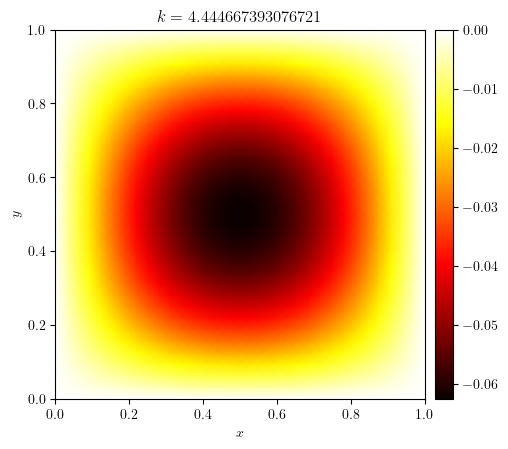

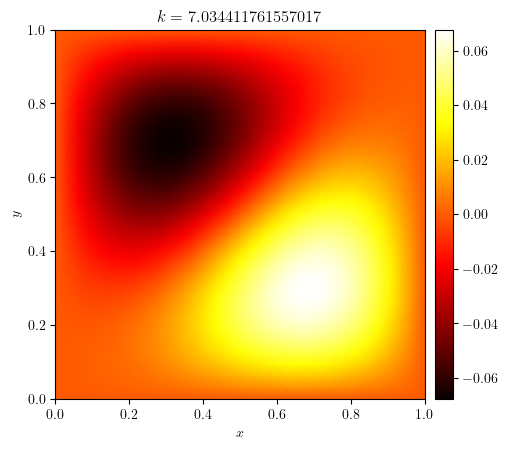

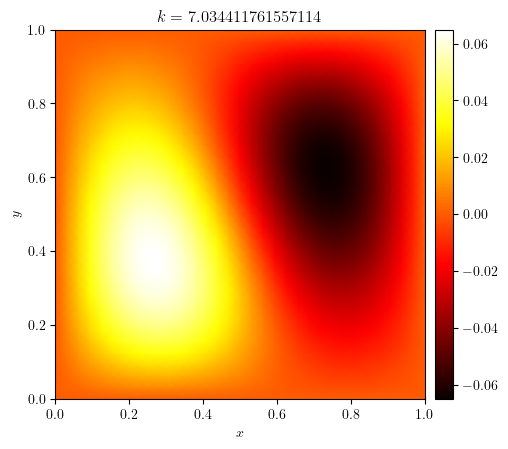

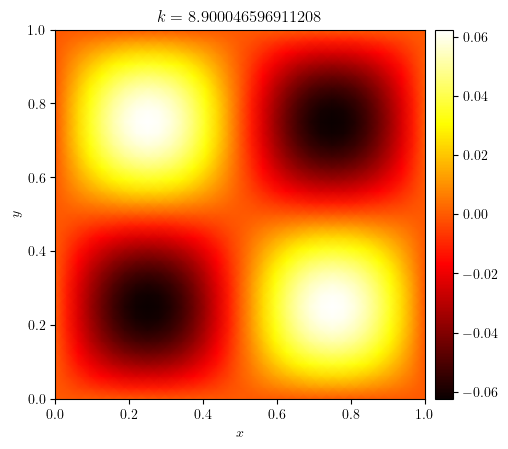

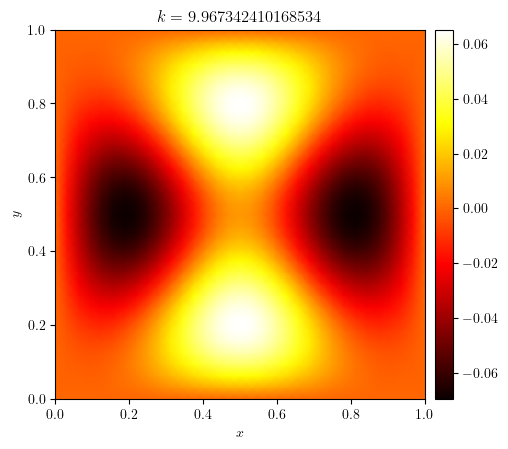

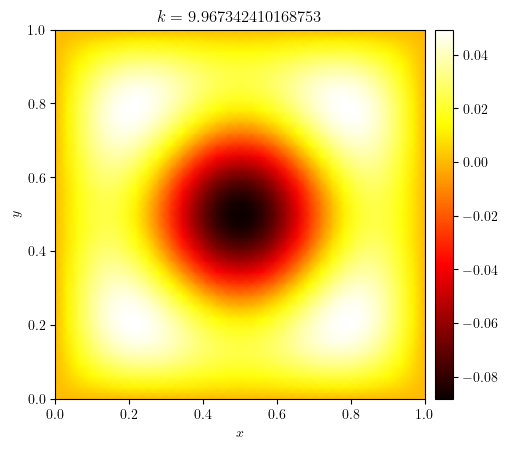

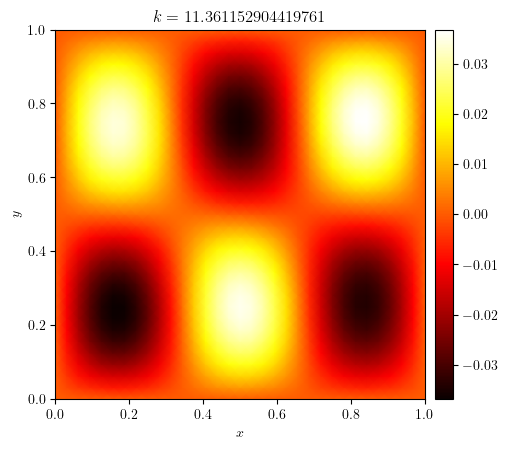

: 

In [ ]:
for k, u in zip(k_values, solver.eigenfunctions):
    if k is not None:
        fig, ax = plot_colormap(u, title=f'$k={k}$')
        write(fig, f'A14_helmholtz_k={k:.3f}', './figures', close=False, pickle=False)

## Boundary value problem ($s\neq0$) example

$$\Omega = [0, L_x] \times [0, L_y]$$

$$u(x=0,y)=u(x=L_x,y)=u(x,y=0)=u(x,y=L_y)=0$$

$$s(x,y)=\sin(2\pi x/L_x)\sin(2\pi y/L_y)$$

In [ ]:
Lx = 2.0
Ly = 1.0

k = 1.0
s = lambda x: np.sin(2 * np.pi * x[0] / Lx) * np.sin(2 * np.pi * x[1] / Ly)

solver = helmholtz_2d_solver(Lx, Ly, 32, 32, k=k, s=s)
solver.solve()

In [ ]:
u = solver.solution
fig, ax = plot_colormap(u, title=f'$k={k}$')
write(fig, f'A14_helmholtz_bvp', './figures', close=False, pickle=False)